### TensorFlow architecture

!['TensorFlow'](image6.png)

### Load librariess

In [1]:
from __future__ import print_function

In [2]:
import numpy as np
from tqdm import tqdm
import sys
import tensorflow as tf

#keras
# tensorflow.keras is coming in TensorFlow 1.4
from tensorflow.contrib.keras.python.keras.datasets import mnist
from tensorflow.contrib.keras.python.keras.models import Sequential, Model
from tensorflow.contrib.keras.python.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.contrib.keras.python.keras.layers import Activation
from tensorflow.contrib.keras.python.keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

### Utility function

In [3]:
import random

def draw_random_digits(X, nrows, ncols):
    if nrows*ncols > X.shape[0]:
        print("Error: Asked to print more digits than elements in the array")
        return
    
    fig = plt.subplots(nrows, ncols, figsize=(2*nrows, 2*ncols))
    
    if len(X.shape) == 4:
        X = X.reshape(X.shape[0:3])
    for r in range(0, nrows):
        for c in range(0, ncols):
            plt.subplot(nrows, ncols, r*ncols+c+1);
            plt.imshow(X[random.randint(0, X.shape[0]-1)], cmap='gray');

### Loading MNIST data

In [4]:
number_to_generate = 3

(X_train, y_train), _ = mnist.load_data()

X_train = X_train[y_train==number_to_generate]

# normalize the data between -1 and 1
X_train = (X_train - 127.5) / 127.5
X_train = np.expand_dims(X_train, -1)

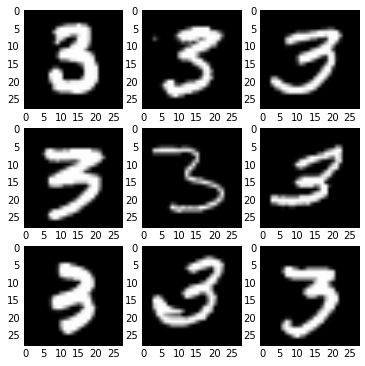

In [5]:
draw_random_digits(X_train, 3, 3)

![GANs](gans.png)

### Deep Convolutional Generative Adversarial Networks

![DCGAN](dcgan.png)

### Build GAN graph

In [6]:
# common parameters
adam_lr = 0.0002
adam_beta_1 = 0.5
kernel_initializer = 'he_normal'
kernel_size = 3 # Convolution kernel size

#### Discriminator graph

The discriminator is made up of 2 convolutional layers followed by a full-connected layer. It ends with a 1 variable that is converted into a probability using a sigmoid function.

The activation function is LeakyReLU as in the DCGAN paper.

In [7]:
D_filters = 8
lrelu_alpha = 0.2

# Discriminator
D = Sequential()

D.add(Conv2D(D_filters, kernel_size=kernel_size, padding='same',
            strides=(2, 2), kernel_initializer=kernel_initializer, input_shape=(28, 28, 1)))

D.add(LeakyReLU(lrelu_alpha))

D.add(Conv2D(2*D_filters, kernel_size=kernel_size, padding='same',
            strides=(2, 2), kernel_initializer=kernel_initializer))

D.add(LeakyReLU(lrelu_alpha))

D.add(Flatten())
D.add(Dense(1, activation='sigmoid'))

D.compile(loss='binary_crossentropy', optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1))
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 8)         80        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 785       
Total params: 2,033
Trainable params: 2,033
Non-trainable params: 0
_________________________________________________________________


#### Generator graph

The generator is made up of a full connected layer followed up two transposed convolution layers. ReLUs is used for activation.

In [8]:
G_filters = 32
z_dim = 8

G = Sequential()
G.add(Dense(2*G_filters*7*7, input_dim=z_dim))
G.add(Reshape((7, 7, 2*G_filters)))
G.add(Activation('relu'))

G.add(Conv2DTranspose(filters=G_filters, kernel_size=kernel_size, strides=(2,2), padding='same'))

G.add(Activation('relu'))

G.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, strides=(2,2), padding='same', activation='tanh'))

G.compile(loss='binary_crossentropy', optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1))
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3136)              28224     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 32)        18464     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 46,977
Trainable params: 46,977
Non-trainable params: 0
_________________________________________________________________


#### Build GAN

In [9]:
D.trainable = False
gan_input = Input(shape=(z_dim,))
x = G(gan_input)
gan_output = D(x)
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1))

### Training

In [10]:
def train(epochs=1, batch_size=64):
    steps = int(X_train.shape[0] / batch_size)
    print('Epochs:', epochs)
    print('Batch size:', batch_size)
    print('Steps per epoch:', steps)
    sys.stdout.flush()
    
    D_loss = []
    G_loss = []
    
    D_real = []
    D_fake = []
    
    for epoch in range(epochs):
        for _ in tqdm(range(steps)):
            real_images = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            z = np.random.normal(0, 1, size=[batch_size, z_dim])
            
            # Train discriminator
            fake_images = G.predict(z)
            X = np.concatenate([real_images, fake_images])

            D_labels = np.zeros(2*batch_size)
            D_labels[:batch_size] = 1

            D.trainable = True
            D_loss.append(D.train_on_batch(X, D_labels))
            D_real.append(D.predict(real_images).mean())
            D_fake.append(D.predict(fake_images).mean())

            # Train generator
            D.trainable = False
            G_loss.append(gan.train_on_batch(z, np.ones(batch_size)))
    
    return D_loss, G_loss, D_real, D_fake

In [11]:
D_loss, G_loss, D_real, D_fake = train(epochs=10, batch_size=32)

Epochs: 10
Batch size: 32
Steps per epoch: 191


100%|██████████| 191/191 [00:11<00:00, 16.38it/s]


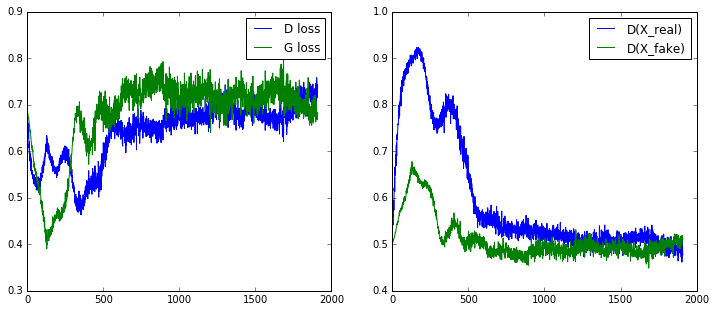

In [12]:
fig = plt.figure(figsize=(12,5));
plt.subplot(121);
plt.plot(D_loss, label='D loss');
plt.plot(G_loss, label='G loss');
plt.legend();
plt.subplot(122);
plt.plot(D_real, label='D(X_real)');
plt.plot(D_fake, label='D(X_fake)');
plt.legend();

### Test

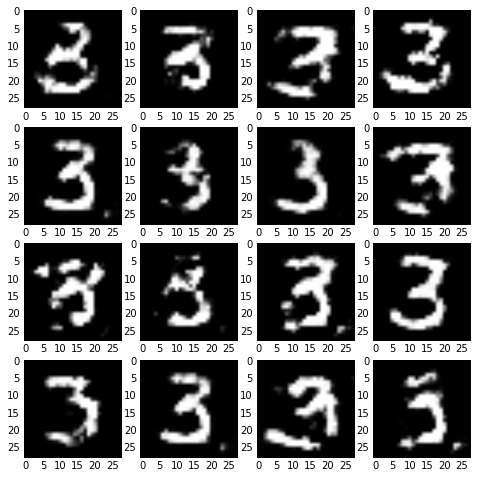

In [13]:
z = np.random.normal(0, 1, size=[64, z_dim])
fake_images = G.predict(z)
draw_random_digits(fake_images, 4, 4)